In [8]:
#데이터 시각화 라이브러리
import seaborn as sns
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.family':'AppleGothic'})
mpl.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'



#CPU만 작동하게 하는 명령어(for Mac)
import tensorflow as tf
tf.config.list_physical_devices()
tf.config.experimental.set_visible_devices([], 'GPU')

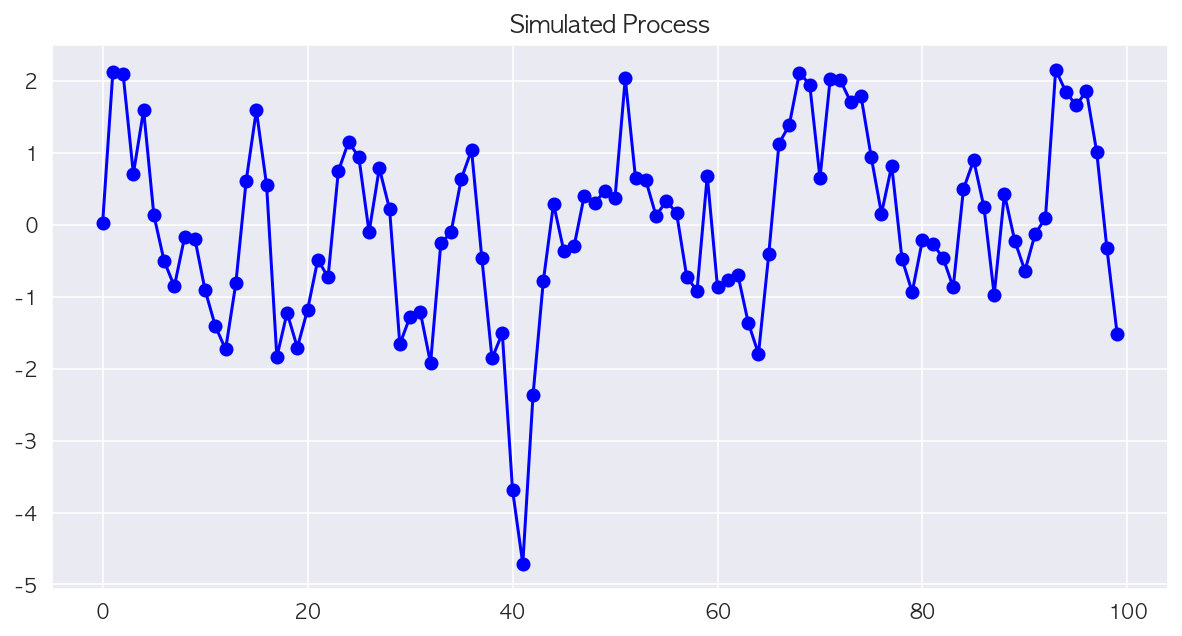

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf , plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 데이터 생성하기
ar = np.array([1, -0.8, 0.2])
ma = np.array([1])
my_simulation = ArmaProcess(ar,ma).generate_sample(nsample=100)

plt.figure(figsize=[10,5]) ; # 그림의 크기 설정
plt.plot(my_simulation, linestyle = '-', marker = 'o', color = 'b')
plt.title("Simulated Process")
plt.show()

There are 1511 observations in the training data
There are 251 observations in the test data


<AxesSubplot:xlabel='Date'>

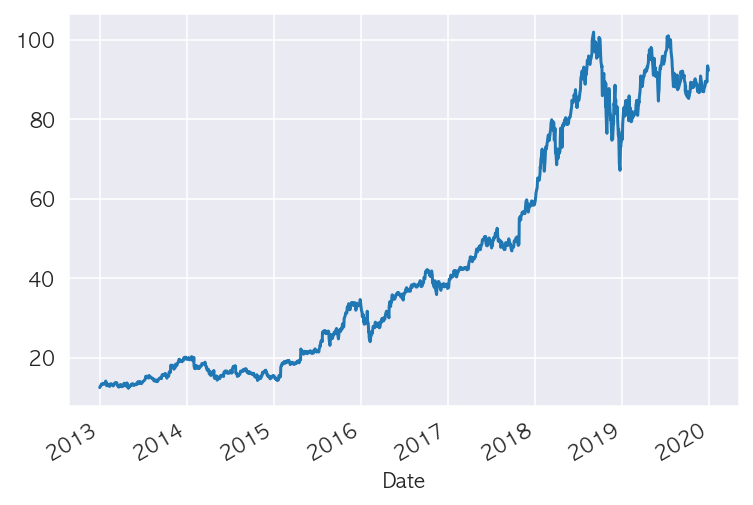

In [10]:
# !pip install yfinance
import pandas as pd
import yfinance as yf
AMZN = yf.download('AMZN',
                   start = '2013-01-01',
                   end = '2019-12-31',
                   progress = False)
all_data = AMZN[['Adj Close', 'Open', 'High','Low',"Close","Volume"]].round(2)
all_data.head(10)

print("There are "+str(all_data[:'2018'].shape[0])+" observations in the training data")
print("There are "+str(all_data['2019':].shape[0])+" observations in the test data")
all_data['Adj Close'].plot()


In [11]:
def ts_train_test(all_data, time_steps, for_periods):
    """
    input:
     data: dataframe with dates and price data
    output:
     X_train, y_train: data from 2013/1/1-2018-12/31
     X_test : data from 2019 -
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    """
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps, ts_train_len - 1):
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshapng X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

    # Preparing to creat X_test
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps, ts_test_len+ time_steps- for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, y_train, X_test

X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0], X_train.shape[1]

(1505, 5)

In [12]:
# Convert the 3D shape of X_train to a data frame so we can see:
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1505 samples in the training data
There are 249 samples in the test data


In [13]:
X_train_see

,0,1,2,3,4
0,12.54,12.87,12.92,12.96,13.42
1,12.87,12.92,12.96,13.42,13.32
2,12.92,12.96,13.42,13.32,13.32
3,12.96,13.42,13.32,13.32,13.27
4,13.42,13.32,13.32,13.27,13.40
...,...,...,...,...,...
1500,79.60,76.05,77.57,74.75,73.04
1501,76.05,77.57,74.75,73.04,68.87
1502,77.57,74.75,73.04,68.87,67.20
1503,74.75,73.04,68.87,67.20,73.54


8/8 [==============================] - 0s 736us/step


(2568.5994, <AxesSubplot:xlabel='Date'>)

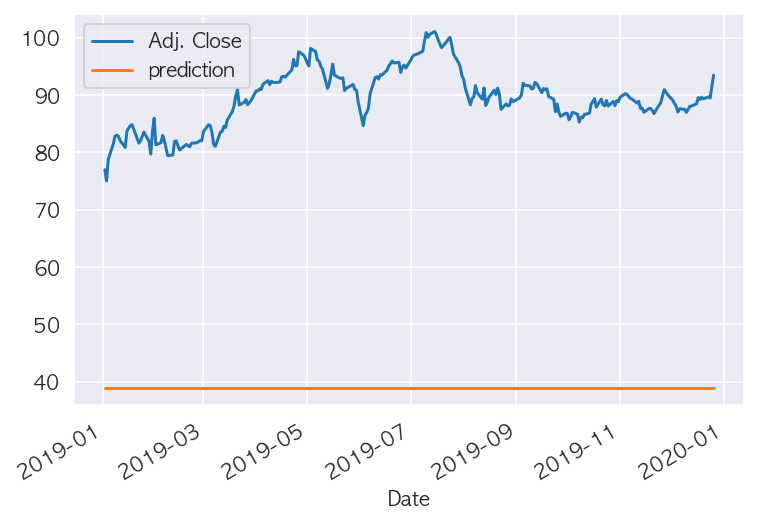

In [14]:
def simple_rnn_model(X_train, y_train, X_test):
    """
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    """
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences = True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train,y_train, epochs = 100, batch_size = 150, verbose = 0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

actual_pred_plot(rnn_predictions)